In [116]:
import pandas as pd
import geopandas as gpd
from access import Access, weights, Datasets
import matplotlib.pyplot as plt
import os

# How to Use `access` to Compute Access Scores to Resources Given XY Coordinates
A common use case for using `access` is to calculate access scores from an origin tract to the aggregated resources available within a destination tract's population weighted centroid. In certain cases, we might be interested in measuring access to the exact locations of the resource, such as a hospital or grocery store. While the [pre-computed Travel Cost matrix](https://access.readthedocs.io/en/latest/resources.html) would not be useful for this use case, the `access` package can still be used to calculate the euclidean distances from origin tracts' population weighted centroids to the resource located at specific coordinates. 

In this notebook, we'll show an example of calculating access scores to individual hospitals in Cook County (and nearby) from Cook County census tract origins given the exact coordinates of those hospitals. 

We'll show you how to:
- [Join Cook County population data with a geospatial dataset for Cook County Census tracts](http://localhost:8888/notebooks/Projects/access/notebooks/How%20to%20Use%20access%20%20to%20Compute%20Access%20to%20Locations%20Given%20X%20Y%20Coordinates.ipynb#Join-Population-Data-with-Geospatial-Representation-of-Census-Tracts)
- [Load in Cook County Hospital data and create geometric points from the XY coordinates](#Load-Cook-County-Hospital-Data-and-Create-Geometric-Points-from-the-XY-Coordinates)
- [Calculate euclidean distances between each of the Cook County Census tracts and the hospitals](#Calculating-Euclidean-Distances-Between-Hospitals-and-Census-Tracts)
- [Calculate access measures](#Calculate-Access-Measures)
- [Saving calculated access measures to a CSV](#Saving-Access-Measures-to-a-CSV)

**Limitation**: A limitation to using the approach shown below is that euclidean distances do not factor in travel times as our [pre-calculated Travel Cost matricies](https://access.readthedocs.io/en/latest/resources.html) do. If you wanted to use our pre-computed travel cost matricies, you could join the hospital locations to the Census Tracts they are located in. To take this approach has its own limitation - distances would no longer be from the center of one Census tract to the exact hospital location(s). They would be from one Census Tract's population weighed centroid to that of another. In any case, joining the hospital data to its Census Tract enables you to use the pre-calculated Travel Cost matrix. See our notebook [**How to Subset the Travel Cost Matricies**](./How%20to%20Subset%20the%20Travel%20Cost%20Matricies.ipynb) and the [**How to Use `access` to Compute Access Scores to Resources Given XY Coordinates Joined to Census Tracts**](./How%20to%20Use%20%60access%60%20to%20Compute%20Access%20Scores%20to%20Resources%20Given%20XY%20Coordinates%20Joined%20to%20Census%20Tracts.ipynb) for an example of this other approach.

## Join Population Data with Geospatial Representation of Census Tracts
To complete this first step, we'll need two files:
- Cook County population data at the census tract level
- geospatial representation of Cook County Census Tracts

First, we'll load a dataset containing population counts for Cook County at the Census Tract level.

In [74]:
cook_county_population['OriginID'] = range(1, len(cook_county_population) + 1)

cook_county_population.head(2)

,OBJECTID,OA11CD,LSOA11CD,MSOA11CD,WD11CD_BF,WD11NM_BF,LAD11CD,LAD11NM,RGN11CD,RGN11NM,...,MSOA11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,ORIG_FID,geometry,OriginID
0,8,E00175260,E01004722,E02000963,E05000642,Queen's Park,E09000033,Westminster,E12000007,London,...,Westminster 004,334,334,0,556.7,103,3.2,7,MULTIPOINT (524567.945 182666.384),1
1,10561,E00023851,E01004722,E02000963,E05000642,Queen's Park,E09000033,Westminster,E12000007,London,...,Westminster 004,419,381,38,253.9,144,2.6,10560,MULTIPOINT (524607.241 182698.350),2


In [ ]:
cook_county_population = gpd.read_file("OA_west_point3.geojson")
cook_county_population.head()

# 读取第二个GeoJSON文件并转换为数据框
#chi_bpk = gpd.read_file("cycleparking_point.geojson")

Next, we'll load in a `.geojson` file of Cook County Census Tracts. ***To see how to produce a `.geojson` file starting from a larger shapefile, see our notebook [How to Subset a Geospatial Shapefile and Convert to .geojson](./How%20to%20Read%2C%20Filter%2C%20and%20Convert%20Shapefiles%20to%20.geojson.ipynb).***

,OBJECTID,OA11CD,LSOA11CD,MSOA11CD,WD11CD_BF,WD11NM_BF,LAD11CD,LAD11NM,RGN11CD,RGN11NM,...,MSOA11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,Shape_Leng,Shape_Area,geometry
0,1,E00175260,E01004722,E02000963,E05000642,Queen's Park,E09000033,Westminster,E12000007,London,...,Westminster 004,334,334,0,556.7,103,3.2,337.211321,5575.259201,"POLYGON ((524523.924 182681.033, 524562.955 18..."
1,2,E00175261,E01004722,E02000963,E05000642,Queen's Park,E09000033,Westminster,E12000007,London,...,Westminster 004,323,323,0,266.9,104,3.1,555.645491,12447.714275,"POLYGON ((524562.955 182712.988, 524523.924 18..."
2,3,E00024125,E01004765,E02000972,E05000649,West End,E09000033,Westminster,E12000007,London,...,Westminster 013,209,209,0,254.9,128,1.6,552.257371,7325.252823,"POLYGON ((529139.846 181684.703, 529160.000 18..."
3,4,E00024126,E01004765,E02000972,E05000649,West End,E09000033,Westminster,E12000007,London,...,Westminster 013,189,189,0,304.8,122,1.5,476.594908,6180.000131,"POLYGON ((529079.176 181634.037, 529053.561 18..."
4,5,E00023936,E01004736,E02000977,E05000644,St James's,E09000033,Westminster,E12000007,London,...,Westminster 018,463,256,207,13.9,141,1.8,3171.614576,336431.415527,"POLYGON ((529656.219 179898.046, 529469.883 17..."


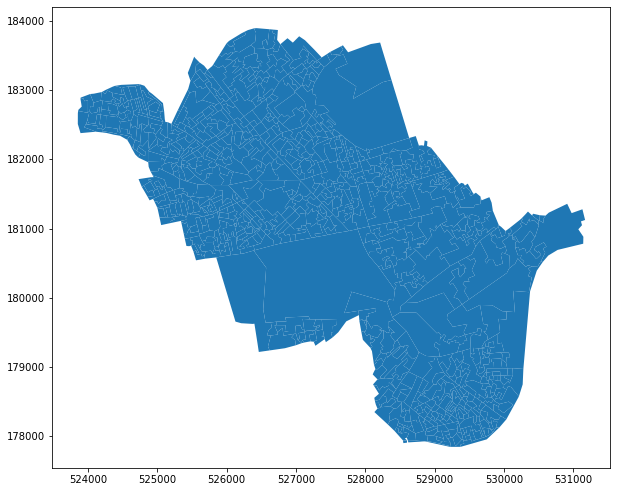

In [70]:
cook_county_tracts = gpd.read_file("OA_west.shp")
cook_county_tracts.plot(figsize=(10, 10))
cook_county_tracts.head(2)

In [85]:
cook_county_tracts['OriginID'] = range(1, len(cook_county_tracts) + 1)

cook_county_tracts.head(2)

,OBJECTID,OA11CD,LSOA11CD,MSOA11CD,WD11CD_BF,WD11NM_BF,LAD11CD,LAD11NM,RGN11CD,RGN11NM,...,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,Shape_Leng,Shape_Area,geometry,OriginID
0,1,E00175260,E01004722,E02000963,E05000642,Queen's Park,E09000033,Westminster,E12000007,London,...,334,334,0,556.7,103,3.2,337.211321,5575.259201,"POLYGON ((524523.924 182681.033, 524562.955 18...",1
1,2,E00175261,E01004722,E02000963,E05000642,Queen's Park,E09000033,Westminster,E12000007,London,...,323,323,0,266.9,104,3.1,555.645491,12447.714275,"POLYGON ((524562.955 182712.988, 524523.924 18...",2


Now we will join the geospatial representations of Cook County Tracts to the population data and plot the population numbers so that we can see the differences at the tract level.

In [4]:
''
cook_county_geopop = cook_county_tracts.merge(cook_county_population, on="OA11CD")
cook_county_geopop.plot(column="USUALRES", figsize=(10, 10))
cook_county_geopop.head()
'''

SyntaxError: incomplete input (937168482.py, line 5)

## Load Bike Parking Points Data and Create Geometric Points from the XY Coordinates
Next up, well load the  Bike Parking Points which has an XY coordinate pair for each parking site. Using the XY coordinates, we will create geospatial points which can then be used to calculate the distances between the cencus tracts and hospitals.

In [71]:
cook_county_parking = gpd.read_file("cycleparking_point.geojson")
cook_county_parking.head()

,FEATURE_ID,SVDATE,PRK_CARR,PRK_COVER,PRK_SECURE,PRK_LOCKER,PRK_SHEFF,PRK_MSTAND,PRK_PSTAND,PRK_HOOP,...,PRK_WHEEL,PRK_HANGAR,PRK_TIER,PRK_OTHER,PRK_PROVIS,PRK_CPT,BOROUGH,PHOTO1_URL,PHOTO2_URL,geometry
0,RWG058844,2017-09-07,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,1,2,Westminster,https://cycleassetimages.data.tfl.gov.uk/RWG05...,https://cycleassetimages.data.tfl.gov.uk/RWG05...,MULTIPOINT (529156.639 181694.426)
1,RWG058835,2017-09-07,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,...,FALSE,FALSE,FALSE,FALSE,1,2,Westminster,https://cycleassetimages.data.tfl.gov.uk/RWG05...,https://cycleassetimages.data.tfl.gov.uk/RWG05...,MULTIPOINT (529110.981 181602.407)
2,RWG058853,2017-09-07,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,1,2,Westminster,https://cycleassetimages.data.tfl.gov.uk/RWG05...,https://cycleassetimages.data.tfl.gov.uk/RWG05...,MULTIPOINT (529195.040 181676.004)
3,RWG057508,2017-06-28,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,3,6,Westminster,https://cycleassetimages.data.tfl.gov.uk/RWG05...,https://cycleassetimages.data.tfl.gov.uk/RWG05...,MULTIPOINT (529138.362 181613.145)
4,RWG058838,2017-09-07,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,...,FALSE,FALSE,FALSE,FALSE,1,2,Westminster,https://cycleassetimages.data.tfl.gov.uk/RWG05...,https://cycleassetimages.data.tfl.gov.uk/RWG05...,MULTIPOINT (529109.971 181576.963)


Using the dataset above, we can create a [`geopandas.GeoDataFrame`](http://geopandas.org/reference/geopandas.GeoDataFrame.html) and with the `gpd.points_from_xy` create geometric points for each hospital.

In [72]:
cook_county_parking['DesID'] = range(1, len(cook_county_parking) + 1)
cook_county_parking.describe()

,PRK_PROVIS,PRK_CPT,DesID
count,1606.000000,1606.000000,1606.000000
mean,3.315068,6.706725,803.500000
std,3.243068,6.488565,463.756581
min,1.000000,1.000000,1.000000
25%,1.000000,2.000000,402.250000
50%,2.000000,4.000000,803.500000
75%,4.000000,8.000000,1204.750000
max,34.000000,68.000000,1606.000000


We can now plot these points on top of the Census Tracts.

<AxesSubplot:>

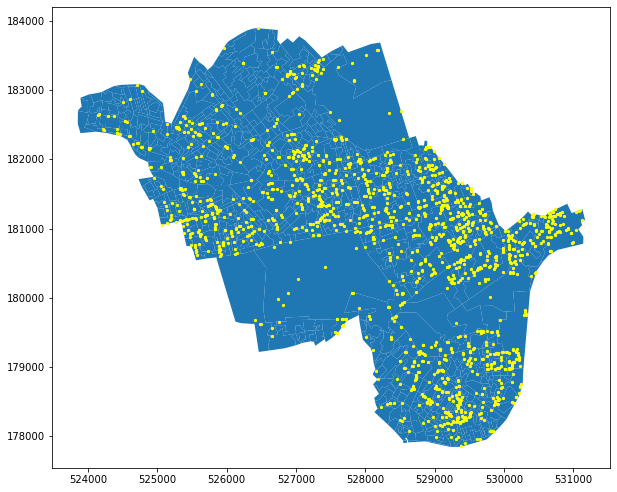

In [73]:
base = cook_county_tracts.plot(figsize=(10, 10))
cook_county_parking.plot(ax=base, color="yellow", markersize=5, figsize=(10, 10))

## Calculating Euclidean Distances Between Hospitals and Census Tracts
Now that we have geometric representations of both Cook County Census Tracts and the hospitals, we can use the `access` package's [`access.euclidean_distance()`](https://access.readthedocs.io/en/latest/generated/access.access.euclidean_distance.html#access.access.euclidean_distance) method to calculate euclidean distances (in meters with the current projection) between each Census Tract and hospital within a max threshold distance. In this example, we will calculate distances from origin Census Tracts and hospitals up to 100km away.

First, we'll instantiate an instance of the `access` class by providing it our demand and supply datasets, the Cook County poulation data and hospital data, respectively.

In [75]:
cook_parking_access = Access(
    demand_df=cook_county_population,
    demand_index="OriginID",
    demand_value="USUALRES",
    supply_df=cook_county_parking,
    supply_index="DesID",
    supply_value="PRK_CPT",
)

Now, we can calculate the euclidean distances between the centroids of our demand and supply geometries, applying the 100,000 meter threshold.

In [76]:
cook_parking_access.create_euclidean_distance(
    name="euclidean", threshold=5000, centroid_d=True, centroid_o=True
)
cook_parking_access.cost_df.head()

,euclidean,origin,dest
0,4690.501868,1,1
1,4665.963846,1,2
2,4731.897358,1,3
3,4690.204939,1,4
4,4670.850036,1,5


In [77]:

# 检查euclidean列中的空值
null_values = cook_parking_access.cost_df['euclidean'].isnull()

null_count = null_values.sum()
print(f"Number of null values in 'euclidean' column: {null_count}")

Number of null values in 'euclidean' column: 0


## Calculate Access Measures
Having calculated our cost matrix with euclidean distances as our cost measure, we can now begin to calculate access scores. Below we show how to calculate and visualize gravity model scores and a custom, user-defined weighted step function.

### Gravity Model
To calculate a gravity score, we must first define a gravity weight function. Once we've defined our weight function, we can pass that as an argument to the [`access.weighted_catchment()`](https://access.readthedocs.io/en/latest/generated/access.fca.weighted_catchment.html#access.fca.weighted_catchment) method. After calling the method, you'll see access score output.

In [78]:
#gravity = weights.gravity(scale=60, alpha=-1)
gravity = weights.gravity(scale=1000, alpha=-1)

weighted = cook_parking_access.weighted_catchment(name="gravity", weight_fn=gravity)

weighted.head()

,gravity_PRK_CPT
OriginID,
1,3055.424281
2,2999.908111
3,2877.145240
4,8995.490700
5,8365.560016


In [79]:
weighted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 783 entries, 1 to 783
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gravity_PRK_CPT  783 non-null    float64
dtypes: float64(1)
memory usage: 12.2 KB


In [80]:
# 检查gravity_PRK_CPT列中的空值
null_values = weighted['gravity_PRK_CPT'].isnull()

null_count = null_values.sum()
print(f"Number of null values in 'gravity_PRK_CPT' column: {null_count}")

Number of null values in 'gravity_PRK_CPT' column: 0


In [83]:
# 将 'weighted' 数据框的索引转换为列，假设索引名为 'OriginID'
weighted_reset = weighted.reset_index().rename(columns={'index': 'OriginID'})
weighted_reset.head(2)

,OriginID,gravity_PRK_CPT
0,1,3055.424281
1,2,2999.908111


In [86]:
cook_county_tracts = pd.merge(cook_county_tracts, weighted_reset, on='OriginID', how='left')

# 检查合并后的GeoDataFrame的前几行，确保联接正确。
cook_county_tracts.head(2)

,OBJECTID,OA11CD,LSOA11CD,MSOA11CD,WD11CD_BF,WD11NM_BF,LAD11CD,LAD11NM,RGN11CD,RGN11NM,...,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,Shape_Leng,Shape_Area,geometry,OriginID,gravity_PRK_CPT
0,1,E00175260,E01004722,E02000963,E05000642,Queen's Park,E09000033,Westminster,E12000007,London,...,334,0,556.7,103,3.2,337.211321,5575.259201,"POLYGON ((524523.924 182681.033, 524562.955 18...",1,3055.424281
1,2,E00175261,E01004722,E02000963,E05000642,Queen's Park,E09000033,Westminster,E12000007,London,...,323,0,266.9,104,3.1,555.645491,12447.714275,"POLYGON ((524562.955 182712.988, 524523.924 18...",2,2999.908111


Now, we'll plot our gravity score.

In [87]:

# 检查DataFrame中每一行是否有任何NaN值
null_rows = cook_county_tracts.isnull().any(axis=1)
# 计算包含空值的行的数量
num_null_rows = null_rows.sum()
# 打印包含空值的行的数量
print("Number of rows with null values:", num_null_rows)

Number of rows with null values: 0


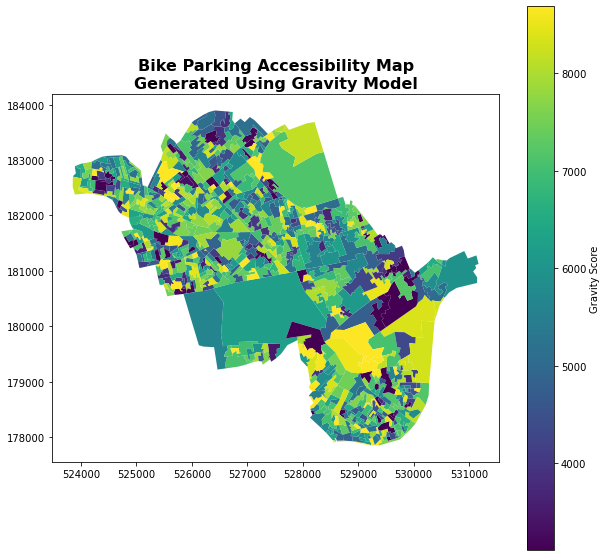

In [120]:
# 绘制基础地图

base = cook_county_tracts.plot(
    column='gravity_PRK_CPT',  # 使用gravity_PRK_CPT列作为颜色映射的依据
    legend=True,               # 显示图例
    cmap="viridis",            # 使用viridis颜色映射
    legend_kwds={"label": "Gravity Score"},  # 设置图例的标签
    figsize=(10, 10),          # 设置图形大小
    vmax=cook_county_tracts['gravity_PRK_CPT'].quantile(0.95),  # 设置最大值
    vmin=cook_county_tracts['gravity_PRK_CPT'].quantile(0.05),  # 设置最小值
)

# 在这里添加标题
plt.title('Bike Parking Accessibility Map\nGenerated Using Gravity Model', fontsize=16, fontweight='bold')

# cook_county_parking.plot(ax=base, color="red", markersize=5)


# 保存图表为PNG格式到output_img文件夹
plt.savefig('output_img/gravity_access.png', dpi=300, bbox_inches='tight')

# 显示带有标题的地图
plt.show()

### Custom Weight Step Function
You can also define your own weight function using the `weights.step_fn()` method. In the example below, we show a step function implemented using the `{distance_threshold_1: weight_1, distance_threshold_2: weight_2, ...:..., distance_threshold_n...: weight_n...}` structure where `distance_threshold_n-1 < distance_threshold_n`.

In [93]:
custom_step_fn = weights.step_fn({500: 1, 1000: 0.8, 2000: 0.5, 3000: 0.3, 4000: 0.2, 5000: 0.1})
weighted_step = cook_parking_access.weighted_catchment(
    name="custom", weight_fn=custom_step_fn
)

weighted_step.head()

access INFO     :: Overwriting custom_PRK_CPT.


,custom_PRK_CPT
OriginID,
1,1756.5
2,1777.5
3,1671.9
4,4656.5
5,4619.0


Now we plot our custom weighted access measure.

In [101]:
cook_county_tracts = pd.merge(cook_county_tracts, weighted_step, on='OriginID', how='left')

# 检查合并后的GeoDataFrame的前几行，确保联接正确。
cook_county_tracts.head(2)

,OBJECTID,OA11CD,LSOA11CD,MSOA11CD,WD11CD_BF,WD11NM_BF,LAD11CD,LAD11NM,RGN11CD,RGN11NM,...,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,Shape_Leng,Shape_Area,geometry,OriginID,gravity_PRK_CPT,custom_PRK_CPT
0,1,E00175260,E01004722,E02000963,E05000642,Queen's Park,E09000033,Westminster,E12000007,London,...,0,556.7,103,3.2,337.211321,5575.259201,"POLYGON ((524523.924 182681.033, 524562.955 18...",1,3055.424281,1756.5
1,2,E00175261,E01004722,E02000963,E05000642,Queen's Park,E09000033,Westminster,E12000007,London,...,0,266.9,104,3.1,555.645491,12447.714275,"POLYGON ((524562.955 182712.988, 524523.924 18...",2,2999.908111,1777.5


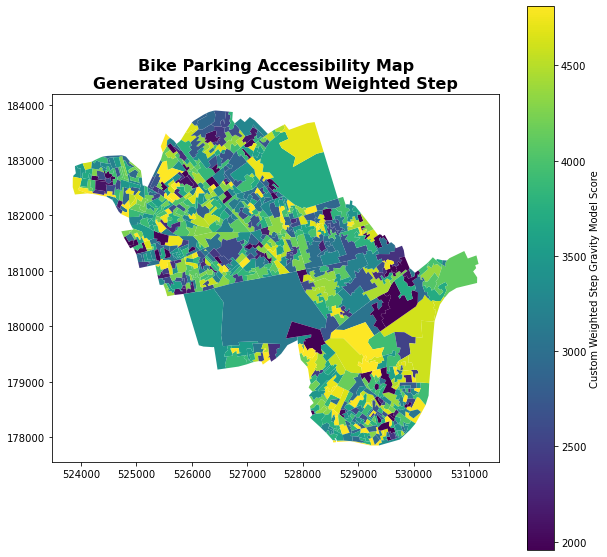

In [102]:
base = cook_county_tracts.plot(
    column='custom_PRK_CPT',  # 使用gravity_PRK_CPT列作为颜色映射的依据
    legend=True,               # 显示图例
    cmap="viridis",            # 使用viridis颜色映射
    legend_kwds={"label": "Custom Weighted Step Gravity Model Score"},  # 设置图例的标签
    figsize=(10, 10),          # 设置图形大小
    vmax=cook_county_tracts['custom_PRK_CPT'].quantile(0.95),  # 设置最大值
    vmin=cook_county_tracts['custom_PRK_CPT'].quantile(0.05),  # 设置最小值
)

# 在这里添加标题
plt.title('Bike Parking Accessibility Map\nGenerated Using Custom Weighted Step', fontsize=16, fontweight='bold')

# cook_county_parking.plot(ax=base, color="red", markersize=5)


# 保存图表为PNG格式到output_img文件夹
plt.savefig('output_img/weighted_step_gravity_access.png', dpi=300, bbox_inches='tight')

# 显示带有标题的地图
plt.show()

### 2SFCA Accessibility

In [104]:
two_stage_fca = cook_parking_access.two_stage_fca(name="2sfca", max_cost=1000)
two_stage_fca.head()

access INFO     :: Overwriting 2sfca_PRK_CPT.


,2sfca_PRK_CPT
OriginID,
1,0.010671
2,0.011538
3,0.009641
4,0.123165
5,0.117375


In [105]:
cook_county_tracts = pd.merge(cook_county_tracts, two_stage_fca, on='OriginID', how='left')

# 检查合并后的GeoDataFrame的前几行，确保联接正确。
cook_county_tracts.head(2)

,OBJECTID,OA11CD,LSOA11CD,MSOA11CD,WD11CD_BF,WD11NM_BF,LAD11CD,LAD11NM,RGN11CD,RGN11NM,...,POPDEN,HHOLDS,AVHHOLDSZ,Shape_Leng,Shape_Area,geometry,OriginID,gravity_PRK_CPT,custom_PRK_CPT,2sfca_PRK_CPT
0,1,E00175260,E01004722,E02000963,E05000642,Queen's Park,E09000033,Westminster,E12000007,London,...,556.7,103,3.2,337.211321,5575.259201,"POLYGON ((524523.924 182681.033, 524562.955 18...",1,3055.424281,1756.5,0.010671
1,2,E00175261,E01004722,E02000963,E05000642,Queen's Park,E09000033,Westminster,E12000007,London,...,266.9,104,3.1,555.645491,12447.714275,"POLYGON ((524562.955 182712.988, 524523.924 18...",2,2999.908111,1777.5,0.011538


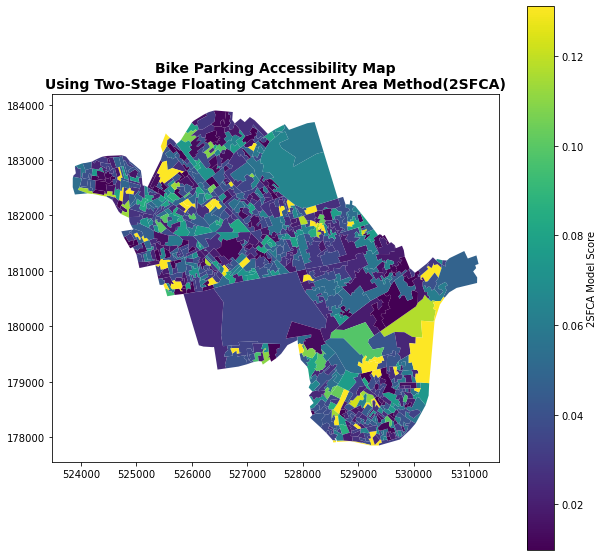

In [119]:
base = cook_county_tracts.plot(
    column='2sfca_PRK_CPT',  # 使用gravity_PRK_CPT列作为颜色映射的依据
    legend=True,               # 显示图例
    cmap="viridis",            # 使用viridis颜色映射

    legend_kwds={"label": "2SFCA Model Score"},  # 设置图例的标签
    figsize=(10, 10),          # 设置图形大小
    vmax=cook_county_tracts['2sfca_PRK_CPT'].quantile(0.95),  # 设置最大值
    vmin=cook_county_tracts['2sfca_PRK_CPT'].quantile(0.05),  # 设置最小值
)

# 在这里添加标题
plt.title('Bike Parking Accessibility Map\nUsing Two-Stage Floating Catchment Area Method(2SFCA)', fontsize=14, fontweight='bold')

# cook_county_parking.plot(ax=base, color="red", markersize=5)

# 保存图表为PNG格式到output_img文件夹
plt.savefig('output_img/2SFCA_access.png', dpi=300, bbox_inches='tight')

# 显示带有标题的地图
plt.show()

### E2SFCA

In [132]:
# Create stepwise distance weight dictionary

# Create stepwise distance weight at 5000 meters
fn5000 = weights.step_fn({100: 0.20, 200: 0.18, 400: 0.16, 800: 0.14, 1200: 0.10, 1600: 0.08, 2000: 0.06, 2400:0.04, 2800:0.02, 3200:0.01, 3600:0.01, 5000:0.0})

# Create stepwise distance weight at 1500 meters
fn1500 = weights.step_fn({100:0.4, 250: 0.2, 500: 0.16, 1000: 0.14, 1500: 0.1, 5000:0.0})

# Create stepwise distance weight at 1000 meters
fn1000 = weights.step_fn({200:0.4, 400: 0.2, 600: 0.16, 800: 0.14, 1000: 0.1, 5000:0.0})

In [123]:
# Try gaussian weights.  Here, we're using a value of 1200 meters, such that we'll be at the 3σ level at 1200 meters.
# weights.gaussian(1200)生成的是一个以1200为中心的高斯分布权重，高斯分布的标准差通常控制了分布的宽度。3σ（标准差）级别意味着高斯分布在距离中心1200米的范围内的权重会有所降低。
# 在本研究中，需求点离自行车站的距离越近越好，而不是随着距离增长得分先增大后减小，因此高斯距离权重在本研究中不适用
# gaussian = weights.gaussian(1200)

In [134]:
E2SFCA1500 = cook_parking_access.enhanced_two_stage_fca(name="2sfca1500", weight_fn=fn1500)
E2SFCA1000 = cook_parking_access.enhanced_two_stage_fca(name="2sfca1000", weight_fn=fn1000)
#G2SFCA = cook_parking_access.enhanced_two_stage_fca(name="g2sfca", weight_fn=gaussian)
#G2SFCA.head()

access INFO     :: Overwriting 2sfca1500_PRK_CPT.
access INFO     :: Overwriting 2sfca1000_PRK_CPT.


In [135]:
E2SFCA1500.head()

,2sfca1500_PRK_CPT
OriginID,
1,0.011157
2,0.011360
3,0.010708
4,0.128785
5,0.119898


In [136]:
E2SFCA1000.head()

,2sfca1000_PRK_CPT
OriginID,
1,0.011744
2,0.012722
3,0.011111
4,0.132316
5,0.124192


In [137]:
cook_county_tracts = pd.merge(cook_county_tracts, E2SFCA1000, on='OriginID', how='left')

# 检查合并后的GeoDataFrame的前几行，确保联接正确。
cook_county_tracts.head(2)

,OBJECTID,OA11CD,LSOA11CD,MSOA11CD,WD11CD_BF,WD11NM_BF,LAD11CD,LAD11NM,RGN11CD,RGN11NM,...,HHOLDS,AVHHOLDSZ,Shape_Leng,Shape_Area,geometry,OriginID,gravity_PRK_CPT,custom_PRK_CPT,2sfca_PRK_CPT,2sfca1000_PRK_CPT
0,1,E00175260,E01004722,E02000963,E05000642,Queen's Park,E09000033,Westminster,E12000007,London,...,103,3.2,337.211321,5575.259201,"POLYGON ((524523.924 182681.033, 524562.955 18...",1,3055.424281,1756.5,0.010671,0.011744
1,2,E00175261,E01004722,E02000963,E05000642,Queen's Park,E09000033,Westminster,E12000007,London,...,104,3.1,555.645491,12447.714275,"POLYGON ((524562.955 182712.988, 524523.924 18...",2,2999.908111,1777.5,0.011538,0.012722


In [138]:
cook_county_tracts = pd.merge(cook_county_tracts, E2SFCA1500, on='OriginID', how='left')

# 检查合并后的GeoDataFrame的前几行，确保联接正确。
cook_county_tracts.head(2)

,OBJECTID,OA11CD,LSOA11CD,MSOA11CD,WD11CD_BF,WD11NM_BF,LAD11CD,LAD11NM,RGN11CD,RGN11NM,...,AVHHOLDSZ,Shape_Leng,Shape_Area,geometry,OriginID,gravity_PRK_CPT,custom_PRK_CPT,2sfca_PRK_CPT,2sfca1000_PRK_CPT,2sfca1500_PRK_CPT
0,1,E00175260,E01004722,E02000963,E05000642,Queen's Park,E09000033,Westminster,E12000007,London,...,3.2,337.211321,5575.259201,"POLYGON ((524523.924 182681.033, 524562.955 18...",1,3055.424281,1756.5,0.010671,0.011744,0.011157
1,2,E00175261,E01004722,E02000963,E05000642,Queen's Park,E09000033,Westminster,E12000007,London,...,3.1,555.645491,12447.714275,"POLYGON ((524562.955 182712.988, 524523.924 18...",2,2999.908111,1777.5,0.011538,0.012722,0.011360


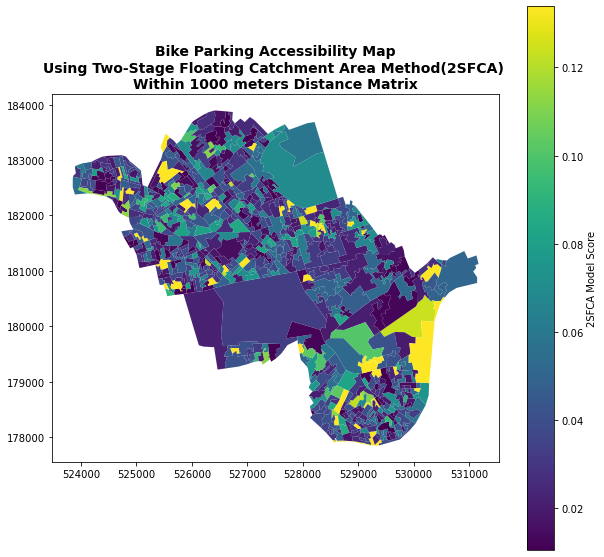

In [145]:
base = cook_county_tracts.plot(
    column='2sfca1000_PRK_CPT',  # 使用gravity_PRK_CPT列作为颜色映射的依据
    legend=True,               # 显示图例
    cmap="viridis",            # 使用viridis颜色映射

    legend_kwds={"label": "2SFCA Model Score"},  # 设置图例的标签
    figsize=(10, 10),          # 设置图形大小
    vmax=cook_county_tracts['2sfca1000_PRK_CPT'].quantile(0.95),  # 设置最大值
    vmin=cook_county_tracts['2sfca1000_PRK_CPT'].quantile(0.05),  # 设置最小值
)

# 在这里添加标题
plt.title('Bike Parking Accessibility Map\nUsing Two-Stage Floating Catchment Area Method(2SFCA) \nWithin 1000 meters Distance Matrix', fontsize=14, fontweight='bold')

# cook_county_parking.plot(ax=base, color="red", markersize=5)

# 保存图表为PNG格式到output_img文件夹
plt.savefig('output_img/2SFCA1000_access.png', dpi=300, bbox_inches='tight')

# 显示带有标题的地图
plt.show()

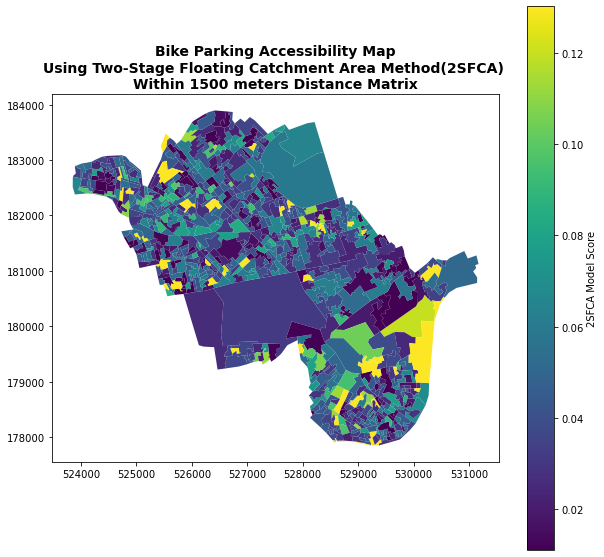

In [144]:
base = cook_county_tracts.plot(
    column='2sfca1500_PRK_CPT',  # 使用gravity_PRK_CPT列作为颜色映射的依据
    legend=True,               # 显示图例
    cmap="viridis",            # 使用viridis颜色映射

    legend_kwds={"label": "2SFCA Model Score"},  # 设置图例的标签
    figsize=(10, 10),          # 设置图形大小
    vmax=cook_county_tracts['2sfca1500_PRK_CPT'].quantile(0.95),  # 设置最大值
    vmin=cook_county_tracts['2sfca1500_PRK_CPT'].quantile(0.05),  # 设置最小值
)

# 在这里添加标题
plt.title('Bike Parking Accessibility Map\nUsing Two-Stage Floating Catchment Area Method(2SFCA) \nWithin 1500 meters Distance Matrix', fontsize=14, fontweight='bold')

# cook_county_parking.plot(ax=base, color="red", markersize=5)

# 保存图表为PNG格式到output_img文件夹
plt.savefig('output_img/2SFCA1500_access.png', dpi=300, bbox_inches='tight')

# 显示带有标题的地图
plt.show()

### 3SFCA

In [139]:
three_stage_fca = cook_parking_access.three_stage_fca(name="3sfca")
three_stage_fca.head(2)

,3sfca_PRK_CPT
OriginID,
1,0.0
2,0.0


In [140]:
cook_county_tracts = pd.merge(cook_county_tracts, three_stage_fca, on='OriginID', how='left')

# 检查合并后的GeoDataFrame的前几行，确保联接正确。
cook_county_tracts.head(2)

,OBJECTID,OA11CD,LSOA11CD,MSOA11CD,WD11CD_BF,WD11NM_BF,LAD11CD,LAD11NM,RGN11CD,RGN11NM,...,Shape_Leng,Shape_Area,geometry,OriginID,gravity_PRK_CPT,custom_PRK_CPT,2sfca_PRK_CPT,2sfca1000_PRK_CPT,2sfca1500_PRK_CPT,3sfca_PRK_CPT
0,1,E00175260,E01004722,E02000963,E05000642,Queen's Park,E09000033,Westminster,E12000007,London,...,337.211321,5575.259201,"POLYGON ((524523.924 182681.033, 524562.955 18...",1,3055.424281,1756.5,0.010671,0.011744,0.011157,0.0
1,2,E00175261,E01004722,E02000963,E05000642,Queen's Park,E09000033,Westminster,E12000007,London,...,555.645491,12447.714275,"POLYGON ((524562.955 182712.988, 524523.924 18...",2,2999.908111,1777.5,0.011538,0.012722,0.011360,0.0


/tmp/ipykernel_4969/1032425056.py:21: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  cook_county_tracts.to_file('Accessibility_Map.shp')


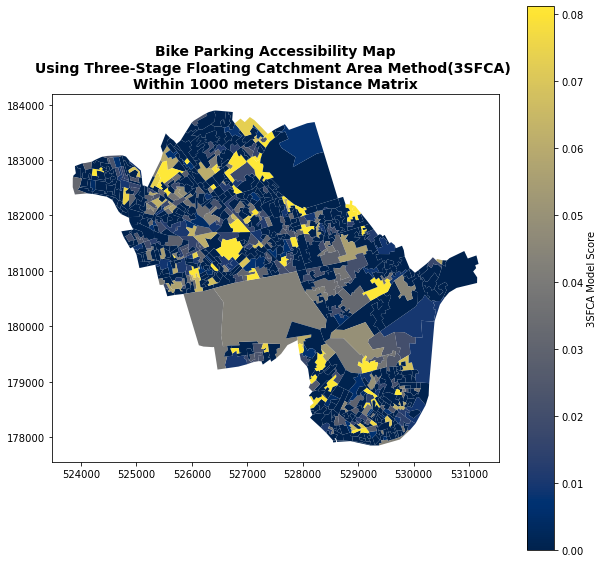

In [143]:
base = cook_county_tracts.plot(
    column='3sfca_PRK_CPT',  # 使用gravity_PRK_CPT列作为颜色映射的依据
    legend=True,               # 显示图例
    cmap="cividis",            # 使用viridis颜色映射

    legend_kwds={"label": "3SFCA Model Score"},  # 设置图例的标签
    figsize=(10, 10),          # 设置图形大小
    vmax=cook_county_tracts['3sfca_PRK_CPT'].quantile(0.95),  # 设置最大值
    vmin=cook_county_tracts['3sfca_PRK_CPT'].quantile(0.05),  # 设置最小值
)

# 在这里添加标题
plt.title('Bike Parking Accessibility Map\nUsing Three-Stage Floating Catchment Area Method(3SFCA) \nWithin 1000 meters Distance Matrix', fontsize=14, fontweight='bold')

# cook_county_parking.plot(ax=base, color="red", markersize=5)

# 保存图表为PNG格式到output_img文件夹
plt.savefig('output_img/2SFCA1000_access.png', dpi=300, bbox_inches='tight')

# 保存地图为SHP文件
cook_county_tracts.to_file('Accessibility_Map.shp')

# 显示带有标题的地图
plt.show()

## Saving Access Measures to a CSV
Finally, view each of the access measures you've calculated by accessing the `access_df` attribute. You can save your access measures to a csv as shown below.